# PDG API tutorial, PyHEP 2024

## Introduction

The goal of this tutorial is to provide a set of examples that illustrate the main concepts and features of the API. Basic familiarity with Python is assumed. Comprehensive documentation is available at https://pdgapi.lbl.gov/doc/

## Installation

First, create a virtual environment and activate it:

```bash
python -m venv ~/pdg.venv
source ~/pdg.venv/bin/activate
```

This ensures that any dependencies will be installed in a self-contained environment.

Now install the package:

```bash
pip install pdg
```

In order to run the examples in this notebook, some additional packages are required:

```bash
pip install numpy matplotlib jupyter
```

You can now launch a Jupyter session (`jupyter lab`) and open this notebook.

## Preamble

The examples that follow all assume that the following preamble has been run:

In [1]:
import pdg
from pdg.particle import PdgParticle
import matplotlib.pyplot as plt
import numpy as np

api = pdg.connect()

## Concepts 

Here we quickly cover some of the basic concepts that apply to the API. Further details can be found in the documentation.

### Editions

There are multiple editions of the PDG database corresponding to the (bi)annual PDG releases. There is also a `pdgall.sqlite` containing data from all historical editions. These databases can be downloaded from the PDG website and provided to the `pdg.connect` function. The default behavior is to use the 2024 database included with the package.

### PDG IDs

*PDG IDs* are used to to identify particles, properties of particles, and other quantities of interest. PDG IDs can have parent PDG IDs; for example, the parent PDG ID for a particle's mass will be the PDG ID of the particle itself. Top-level PDG IDs, such as those of particles, generally take the form of a letter followed by three digits. The PDG ID for a particle property takes the form of the parent PDG ID, a period, then some digits. A specific edition can be appended with a slash.

Unlike Monte Carlo IDs, which always identify specific states, a PDG ID can represent multiple states from a multiplet.

#### The `get` function

The `api.get` function can be passed any PDG ID and will return an instance of the `PdgData` class or one of its subclasses (`PdgParticle`, `PdgMass`, etc.), depending on the type of data associated with the PDG ID.

### Monte Carlo IDs 

Monte Carlo IDs (oftened called "PDG IDs" in the community) are used in MC generators and always identify specific states.

### Summary table values 

Measured quantities, such as particle properties, are summarized by the PDG in *summary tables*, which list the PDG's evaluation (e.g. an average or fit) of the quantity based on measurements in the literature. The individual measurements are listed in *listings*. Currently, the API provides access to summary table values. Support for the listings will be added in the future.

A given PDG ID may have multiple summary table values, corresponding, for example, to different measurement techniques.

#### Parent PDG IDs 

A particle property listed in the summary tables will have the particle itself as its parent PDG ID.

#### Sort order

Quantities may have multiple summary table values, in which case the database specifies their ordering.

#### "Best" properties and summaries

When multiple PDG IDs are available for, e.g., a particle's mass, the API will provide the "best" one when using simple properties such as `PdgParticle.mass`. The "best" one is the one that comes first in the sort order, after filtering out those that apply to other charge states, etc.

Similarly, when multiple summary values are available for a given PDG ID, the API will default to the first one that comes first in the sort order.

In "pedantic" mode, the user is required to choose a PDG ID and/or summary value when multiple options are available.

### Items and their mappings

Decays may be expressed in terms of "generic" particles: pions, leptons, etc. More generally, every "thing" in a decay is a *PDG item*. Some items correspond to specific particle states (MC IDs), while others correspond to other (specific) items, either mapping to one particular item (a *shortcut* or *alias*) or mapping to multiple (a *generic* item). The database defines this map between items. 

## Exercises

### Getting a particle

Particles are represented by the `PdgParticle` class. There are multiple ways to get a particle from the API. Depending on the method, the result can be a `PdgParticleList`, a Python list of `PdgParticle`s, or a specific `PdgParticle`.

#### By name

A particle name can refer to a single particle or to a group of them. The function `get_particle_by_name` will return a `PdgParticle` if there's a unique match, and will raise an exception if not. The function `get_particles_by_name` always returns a list of `PdgParticles`. Aliases will automatically be resolved.

In [2]:
api.get_particle_by_name('pi+')

PdgParticle('S008/2024', name='pi+')

In [3]:
api.get_particles_by_name('pi')

[PdgParticle('S008/2024', name='pi-'),
 PdgParticle('S009/2024', name='pi0'),
 PdgParticle('S008/2024', name='pi+')]

In [4]:
api.get_particles_by_name('N')

[PdgParticle('S017/2024', name='n'),
 PdgParticle('S016/2024', name='p'),
 PdgParticle('S017/2024', name='nbar'),
 PdgParticle('S016/2024', name='pbar')]

In [5]:
api.get_particles_by_name('Xi_c(2980)')

[PdgParticle('B130/2024', name='Xi_c(2970)0'),
 PdgParticle('B130/2024', name='Xibar_c(2970)0')]

In [6]:
api.get_particles_by_name('Xi_c(2970)')

[PdgParticle('B130/2024', name='Xi_c(2970)0'),
 PdgParticle('B130/2024', name='Xibar_c(2970)0')]

#### By MC ID

Since MC IDs are unambiguous, `get_particle_by_mcid` returns a `PdgParticle` directly.

In [7]:
api.get_particle_by_mcid(2212)

PdgParticle('S016/2024', name='p')

#### By PDG ID

The `get` function, given a particle's PDG ID, returns a list of all associated particles. Since `get` must return an instance of a `PdgData` subclass, the return type is a `PdgParticleList`, rather than a simple list of `PdgParticle`s (as returned by `get_particles_by_name`). 

In [8]:
api.get('S008/2024')

PdgParticleList('S008/2024')

However, a simple list is simple to get:

In [9]:
list(_)

[PdgParticle('S008/2024', name='pi+'), PdgParticle('S008/2024', name='pi-')]

A `PdgParticle` can also be instantiated directly.

In [10]:
PdgParticle(api, 'S009/2024')

PdgParticle('S009/2024', name='pi0')

When a PDG ID refers to more than one specific state, either `set_name` or `set_mcid` must be passed.

In [11]:
PdgParticle(api, 'S008/2024', set_name='pi-')

PdgParticle('S008/2024', name='pi-')

### Getting basic properties

Some properties (quantum numbers) are associated directly with a `PdgParticle`.

In [12]:
p = api.get_particle_by_name('pi0')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '1', '-', '0', '-', '+')

In [13]:
p = api.get_particle_by_name('pi+')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(1.0, '1', '-', '0', '-', None)

In [14]:
p = api.get_particle_by_name('gamma')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '0,1', None, '1', '-', '-')

In [15]:
p = api.get_particle_by_name('eta')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '0', '+', '0', '-', '+')

### Getting masses, widths, lifetimes

Masses, widths, and lifetimes are some of the particle properties that have their own PDG IDs. In some cases there may be multiple masses (or widths or lifetimes) for a given particle, corresponding, for example, to different measurement techniques.

For convenience, the `mass`, `width`, and `lifetime` properties of a `PdgParticle` can be used to get the "best" summary value. Widths and lifetimes are automatically interconverted when necessary. The full sets of summary values, as `PdgProperty` (subclass) objects, via the `masses`, `widths`, and `lifetimes` methods.

In [16]:
p = api.get_particle_by_name('pi+')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((0.13957039098368132, [PdgMass('S008M/2024')]),
 (2.5283166082854054e-17, []),
 (2.603313199949126e-08, [PdgLifetime('S008T/2024')]))

TODO: Clarify that PdgProperty.mass,width,lifetime always gives you GeV etc., but PdgMass etc may be encoded in any units. Show the generic way first, and then the shortcut that is fixed to a given unit.

In [54]:
m = api.get('S008M')

In [55]:
m.best_summary().value

139.5703909836813

In [56]:
m.best_summary().units

'MeV'

In [17]:
p = api.get_particle_by_name('pi0')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((0.1349768277676847, [PdgMass('S009M/2024')]),
 (7.811987971364424e-09, []),
 (8.425512205250367e-17, [PdgLifetime('S009T/2024')]))

In [18]:
p = api.get_particle_by_name('gamma')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((1e-27, [PdgMass('S000M/2024')]), (0.0, []), (inf, []))

In [19]:
p = api.get_particle_by_name('t')

(p.mass, list(p.masses())), (p.width, list(p.widths())), (p.lifetime, list(p.lifetimes()))

((172.5746930968864,
  [PdgMass('Q007TP/2024'), PdgMass('Q007TP2/2024'), PdgMass('Q007TP4/2024')]),
 (1.424101758196898, [PdgWidth('Q007W/2024')]),
 (4.621860735804221e-25, []))

TODO: Talk about PdgParticle.mass_error, etc.

### Getting limits on things

Using a basic accessor such as `PdgParticle.mass` will return a value without indicating whether that value is a limit or a measurement. The full `PdgProperty` can be used to get the `PdgSummaryValue` objects that provide this additional information.

In [57]:
p = api.get_particle_by_name('gamma')
p.mass, p.mass_error

(1e-27, None)

TODO: If number is a limit, return None?

In [21]:
m = list(p.masses())[0]

m

PdgMass('S000M/2024')

In [22]:
m.summary_values()

[{'id': 1020000,
  'pdgid_id': 1,
  'pdgid': 'S000M',
  'edition': '2024',
  'value_type': 'L',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': 'U',
  'comment': None,
  'value': 1e-18,
  'error_positive': 0.0,
  'error_negative': 0.0,
  'scale_factor': None,
  'unit_text': 'eV',
  'display_value_text': '<1E-18',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'gamma MASS'}]

In [23]:
summary = m.best_summary()
summary.value_type, summary.is_limit, summary.is_upper_limit, summary.is_lower_limit

('BEST LIMIT', True, True, False)

### Getting a particle's decays

In [24]:
p = api.get_particle_by_name('pi+')

NOTE: Show `branching_fractions` first, then inclusive/exclusive.

In [25]:
list(p.inclusive_branching_fractions())

[]

In [26]:
list(p.exclusive_branching_fractions())

[PdgBranchingFraction('S008.1/2024'),
 PdgBranchingFraction('S008.2/2024'),
 PdgBranchingFraction('S008.4/2024'),
 PdgBranchingFraction('S008.6/2024'),
 PdgBranchingFraction('S008.11/2024'),
 PdgBranchingFraction('S008.10/2024'),
 PdgBranchingFraction('S008.7/2024'),
 PdgBranchingFraction('S008.8/2024'),
 PdgBranchingFraction('S008.9/2024')]

In [27]:
decay = next(p.exclusive_branching_fractions())

In [28]:
decay

PdgBranchingFraction('S008.1/2024')

In [29]:
decay.description

'pi+ --> mu+ nu_mu'

In [30]:
decay.summary_values()

[{'id': 1021202,
  'pdgid_id': 1306,
  'pdgid': 'S008.1',
  'edition': '2024',
  'value_type': 'V',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 99.9877,
  'error_positive': 4e-07,
  'error_negative': 4e-07,
  'scale_factor': None,
  'unit_text': '',
  'display_value_text': '(99.98770+-0.00004)%',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+ --> mu+ nu_mu'}]

In [31]:
decay.value

99.9877

### Iterating over decay products

In [32]:
products = decay.decay_products

In [33]:
prod = products[0]

prod.item, prod.multiplier, prod.subdecay

(PdgItem("mu+"), 1, None)

In [34]:
prod.item.particle

PdgParticle('S004/2024', name='mu+')

In [35]:
prod = products[1]

prod.item, prod.multiplier, prod.subdecay

(PdgItem("nu_mu"), 1, None)

In [36]:
prod.item.particle

PdgParticle('S002/2024', name='nu_mu')

TODO: Now show one where there's a generic item where `.particle` fails

### Getting arbitrary properties

#### Particle-associated properties

In [37]:
v = api.get('Q007TP4')
v.description, v.value, v.units

('t-Quark Pole Mass from Cross-Section Measurements', 172.3523553288312, 'GeV')

In [38]:
v.summary_values()

[{'id': 1021134,
  'pdgid_id': 1175,
  'pdgid': 'Q007TP4',
  'edition': '2024',
  'value_type': 'AC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 172.3523553288312,
  'error_positive': 0.6752618288606228,
  'error_negative': 0.6432013333753764,
  'scale_factor': 1.0,
  'unit_text': 'GeV',
  'display_value_text': '172.4+-0.7',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 't-Quark Pole Mass from Cross-Section Measurements'}]

#### General properties (i.e. not associated with a single particle)

##### Neutrino properties

These live under `S066` and `S067`.

In [39]:
v = api.get('S067P23')
v.description, v.value

('sin**2(theta(23))', 0.5529894603427739)

In [40]:
v.summary_values()

[{'id': 1021101,
  'pdgid_id': 1136,
  'pdgid': 'S067P23',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': 'Assuming inverted mass ordering',
  'value': 0.5529894603427739,
  'error_positive': 0.01557018799120562,
  'error_negative': 0.02376487951333883,
  'scale_factor': 1.053519,
  'unit_text': '',
  'display_value_text': '0.553+0.016-0.024',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'sin**2(theta(23))'},
 {'id': 1021102,
  'pdgid_id': 1136,
  'pdgid': 'S067P23',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': 'Assuming normal mass ordering',
  'value': 0.5579671857245437,
  'error_positive': 0.01540986825925941,
  'error_negative': 0.02051779341399617,
  'scale_factor': 1.0,
  'unit_text': '',
  'display_value_text': '0.558+0.015-0.021',
  'display_power_of_ten': 0,


In [41]:
parent = api.get('S067')

In [42]:
props = list(parent.get_children())

In [43]:
[(prop.baseid, prop.description) for prop in props]

[('S067AER', 'Events (observed/expected) from accelerator nu_mu experiments.'),
 ('S067RER', 'Events (observed/expected) from reactor nubar_e experiments.'),
 ('S067DU0', 'R(mu/e) = (Measured Ratio mu/e) / (Expected Ratio mu/e)'),
 ('S067DU1', 'R(nu_mu) = (Measured Flux of nu_mu) / (Expected Flux of nu_mu)'),
 ('S067DU9',
  'R(mu/total) = (Measured Ratio mu/total) / (Expected Ratio mu/total)'),
 ('S067UDM', 'N(up)(mu)/N(down)(mu)'),
 ('S067UDE', 'N(up)(e)/N(down)(e)'),
 ('S067MER',
  'R(up/down; mu) = (Measured up/down; mu) / (Expected up/down; mu)'),
 ('S067MPM', 'N(mu+)/N(mu-)'),
 ('S067RPM',
  'R(mu+/mu-) = (Measured N(mu+)/N(mu-)) / (Expected N(mu+)/N(mu-))'),
 ('S067SNU', 'nu_e Capture Rates from Radiochemical Experiments'),
 ('S067SES', 'phi(ES) (B8)'),
 ('S067SCC', 'phi(CC) (B8)'),
 ('S067SNC', 'phi(NC) (B8)'),
 ('S067SB8', 'phi(nu_mu+nu_tau) (B8)'),
 ('S067PPT', 'Total Flux of Active --> p p Solar Neutrinos'),
 ('S067B7T', 'Total Flux of Active Be7 Solar Neutrinos'),
 ('S067PET

##### Some CKM elements

In [44]:
[(prop.baseid, prop.description) for prop in api.get('S052').get_children()]

[('S052CB1', '|V_(cb)| * F(1) (from B0 --> D*- lepton+ nu)'),
 ('S052CB2', '|V_(cb)| * G(1) (from B --> D- lepton+ nu)'),
 ('S052A00', '|V(cb)| (from D_s*- mu+ nu_mu)')]

### Getting all the things

To assist in searching the database, the `api.get_all` function can be used to iterate over all PDG IDs. Optionally, an argument can be passed to restrict to a specific type of PDG ID. The set of allowed arguments is specified in the `pdgdoc` table in the SQLite file, under `DATA_TYPE`.

#### Particles

In [45]:
particles = []
for particle_list in api.get_all('PART'):
    for p in particle_list:
        particles.append(p)
particles[:10]

[PdgParticle('S000/2024', name='gamma'),
 PdgParticle('G021/2024', name='g'),
 PdgParticle('G033/2024', name='graviton'),
 PdgParticle('S043/2024', name='W+'),
 PdgParticle('S043/2024', name='W-'),
 PdgParticle('S044/2024', name='Z0'),
 PdgParticle('S126/2024', name='H'),
 PdgParticle('S029/2024', name='Axions (A0) and Other Very Light Bosons'),
 PdgParticle('S003/2024', name='e-'),
 PdgParticle('S003/2024', name='e+')]

#### Decays

In [46]:
descriptions = set()
for particle_list in api.get_all('PART'):
    for p in particle_list:
        for decay in p.branching_fractions():
            descriptions.add(decay.description)
list(descriptions)[:10]

['f_0(1710) --> gamma gamma',
 'D+ --> pi+ pi0 e+ e-',
 'psi(4660) --> chi_c2() gamma',
 'Xi_c()+ --> p phi(1020)',
 'chi_c0(1P) --> K+ K- eta',
 'Xi_b(6227) --> Lambda_b()0 K-  x B(b --> Xi_b(6227))/B(b --> Lambda_b()0)',
 'D0 --> rho0 mu+ mu-',
 'B0 --> rho0 f_0(980) , f_0() --> pi+ pi-',
 'chi_c2(1P) --> pi+ pi- K0S K0S',
 'psi(4040) --> chi_c2 pi+ pi- pi0']

## Fancier exercises

### Printing all $B^0$ decays that produce a $J/\psi$

In [48]:
p = api.get_particle_by_name('B0')
jpsi_name = api.get_canonical_name('J/psi')
jpsi_name

'J/psi(1S)'

In [49]:
for decay in p.exclusive_branching_fractions():
    for decay_product in decay.decay_products:
        item = decay_product.item
        if item.has_particle and item.particle.name == jpsi_name:
            print(f'{decay.description:40s}{decay.display_value_text}')

B0 --> J/psi(1S) K0                     (8.91+-0.21)E-4
B0 --> J/psi(1S) K+ pi-                 (1.15+-0.05)E-3
B0 --> J/psi(1S) eta K0S                (5.4+-0.9)E-5
B0 --> J/psi(1S) eta^' K0S              <2.5E-5
B0 --> J/psi(1S) phi K0                 (4.9+-1.0)E-5
B0 --> J/psi(1S) omega K0               (2.3+-0.4)E-4
B0 --> J/psi(1S) K(1270)0               (1.3+-0.5)E-3
B0 --> J/psi(1S) pi0                    (1.66+-0.10)E-5
B0 --> J/psi(1S) eta                    (1.08+-0.23)E-5
B0 --> J/psi(1S) pi+ pi-                (3.99+-0.15)E-5
B0 --> J/psi rho(1700)0 , rho()0 --> pi+ pi-(2.0+-1.3)E-6
B0 --> J/psi(1S) omega                  (1.8+0.7-0.5)E-5
B0 --> J/psi(1S) K+ K-                  (2.53+-0.35)E-6
B0 --> J/psi(1S) phi                    <1.1E-7
B0 --> J/psi(1S) eta^'(958)             (7.6+-2.4)E-6
B0 --> J/psi(1S) K0 pi+ pi-             (4.5+-0.4)E-4
B0 --> J/psi(1S) K0 K+ K-               (2.5+-0.7)E-5
B0 --> J/psi(1S) K^*(892)+ pi-          (8+-4)E-4
B0 --> J/psi(1S) pi+ pi- 

### Plotting partial widths of radiative decays of $\Upsilon(1S)$ 

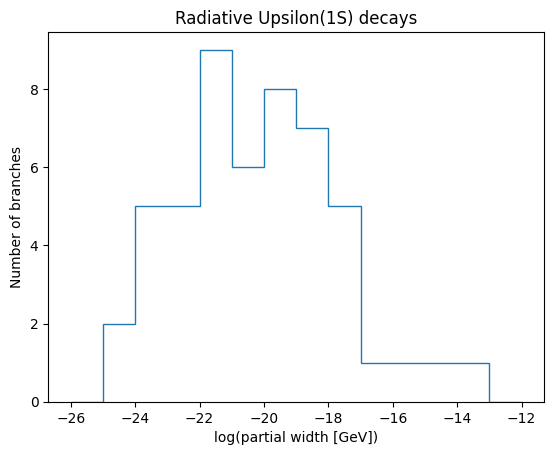

In [50]:
def produces_gamma(branch):
    return any(p.item.has_particle and p.item.particle.name == 'gamma'
               for p in branch.decay_products)

p = api.get_particle_by_name('Upsilon(1S)')
selected_branches = [branch for branch in p.branching_fractions()
                    if produces_gamma(branch)]
log_partial_widths = [np.log(p.width * b.value) for b in selected_branches]

plt.hist(log_partial_widths, histtype='step', bins=np.linspace(-26, -12, 15));
plt.xlabel("log(partial width [GeV])")
plt.ylabel('Number of branches')
plt.title('Radiative Upsilon(1S) decays');

### Plotting masses of all decay products of $D^+$

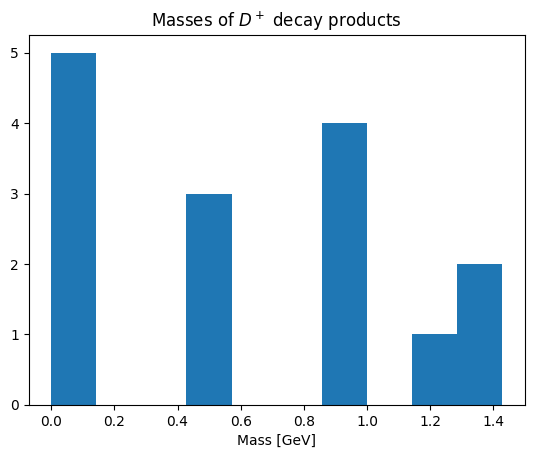

In [51]:
all_masses = set()
# p = api.get_particle_by_name('Upsilon(1S)')
p = api.get_particle_by_name('D0')
for decay in p.exclusive_branching_fractions():
    for p in decay.decay_products:
        if not p.item.has_particle:
            continue
#        mass_prop = next(p.item.particle.masses(), None)
#        if mass_prop is None or mass_prop.value is None:
#            continue
        if p.item.particle.has_mass_entry:
            all_masses.add(p.item.particle.mass)
plt.hist(all_masses);
plt.xlabel('Mass [GeV]')
plt.title('Masses of $D^+$ decay products');

### Plotting $K^+$ mass over time

For this, you will need the "pdgall" database file from https://pdg.lbl.gov/2024/api/index.html.

In [52]:
api_all = pdg.connect("sqlite:///pdgall-2024-v0.1.0.sqlite")

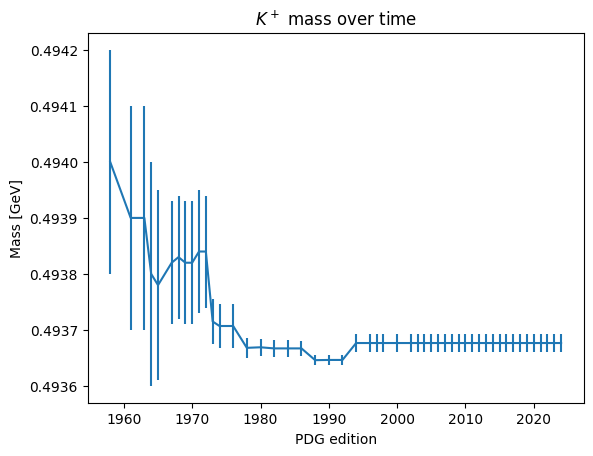

In [53]:
xs, ys, yerrs = [], [], []
for edition in api_all.editions:
    p = api_all.get_particle_by_name('K+', edition=edition)
    if p.has_mass_entry:
        xs.append(int(edition))
        ys.append(p.mass)
        yerrs.append(p.mass_error)

plt.errorbar(xs, ys, yerrs)
plt.xlabel('PDG edition')
plt.ylabel('Mass [GeV]')
plt.title('$K^+$ mass over time');

## Direct access using SQLAlchemy

## Metadata and documentation tables